# Policy iteration & Value iteration

If (1) the following states exist for all possible initial states, (2) the sum of the cumulative rewards exists (even if it is + or - infinity), and (3) all the value functions do not diverge, the solution of the Bellmann optimal equation becomes the optimal value function for the MDP's optimal policy that maximizes cumulative rewards.

Using this principle, we will solve the Bellman equation to solve the MDP. Policy iteration and value iteration, which will be shown next, are particularly applicable to environments that the transition function is known.

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gym
import copy
import time


### Understanding of FrozenLake environment

We will use 'FrozenLake8x8-v0' environment. The purpose of this problem is to start at the starting point and reach the destination without falling into the hole. This environment consists of a grid space, and the transition probability function is known.

At first, we initialize the FrozenLake environment.

In [2]:
env = gym.make('FrozenLake8x8-v0')

Information on maps of Frozenlake is available from the environment's 'desc' attribute.

In [3]:
desc = [[c.decode('utf-8') for c in line] for line in env.desc]
desc

[['S', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
 ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
 ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'],
 ['F', 'F', 'F', 'F', 'F', 'H', 'F', 'F'],
 ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'],
 ['F', 'H', 'H', 'F', 'F', 'F', 'H', 'F'],
 ['F', 'H', 'F', 'F', 'H', 'F', 'H', 'F'],
 ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'G']]

Maps can be visualized using seaborn pakage.<br />
&ensp;&ensp; S: Starting point <br />
&ensp;&ensp; G: Goal point <br />
&ensp;&ensp; F: Frozen (A place where an agent can step on) <br />
&ensp;&ensp; H: Hole (A hole through which the agent can fall) <br />

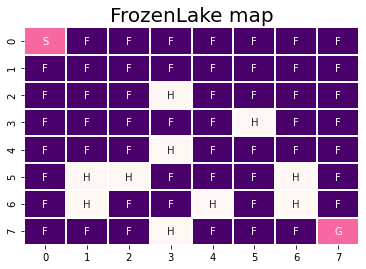

In [4]:
map_to_float = {'S': 0, 'G':0, 'F':1, 'H': -1}
map_float = np.array([map_to_float[i] for i in np.array(desc).flatten()]).reshape(8,8)
plt.title("FrozenLake map", size= 20)
sns.heatmap(map_float, annot=np.array(desc).reshape(8,8), fmt='', cbar=False, linewidths=1, cmap="RdPu")
plt.show()

The agent aims to go from the starting point to the destination point without falling into the hole by choosing the left, down, right and up action at each step. The probability of moving to the intended place is 1/3 because the ground is frozen. <br /> <br />
We are going to solve this problem with policy iteration and value iteration sequentially.

# 1. Policy iteration

Policy iteration is an algorithm that iteratively performs prediction (updating value function) and control (updating policy). This method converges the random initial value function and policy to the optimal value function and optimal policy.

In [5]:
# Initializing Value function and policy
v_table = np.random.randn(env.nS)
policy = np.random.randint(low=0, high=env.nA-1, size=(env.nS)) # greedy policy

We can visualize and check the initial value function. In fact, since the episode ends in the Hole and Goal, the value function has no meaning here. Visualization of the value function excluding the values at these states is as follows.

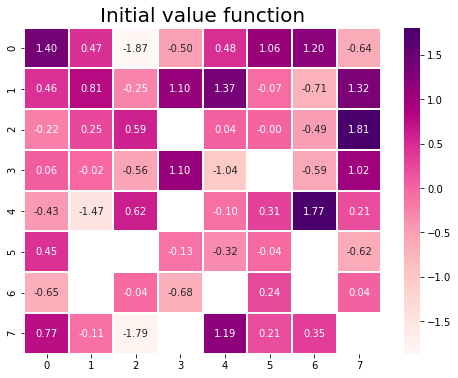

In [6]:
terminal_place = np.array([e in ['H', 'G'] for e in np.array(desc).flatten()])

plt.figure(figsize=(8,6))
plt.title('Initial value function', fontsize=20)
sns.heatmap(data= v_table.reshape(8,8), annot=True, fmt='.2f', linewidths=1, cmap="RdPu", mask=terminal_place.reshape(8,8))
plt.show()

Now we will create a function that serves to evaluate and improve policy. </br >
We will update the value function using the Bellman expectation equation and update the policy using the greedy policy.

In [7]:
def evaluate_policy(env, v_table, policy, in_place= True):
    # update v_table using current policy 
    delta = np.inf 
    i = 0
    while delta > 1e-6:
        i += 1
        v_table_old = copy.deepcopy(v_table) # 
        for s in range(env.nS):
            if terminal_place[s] : continue # we don't need value function here
            a = policy[s]
            if in_place : 
                v_table[s] = np.sum([p * (r + gamma * v_table[s_] * (1- d)) for p, s_, r, d in env.P[s][a]])
            else : 
                v_table[s] = np.sum([p * (r + gamma * v_table_old[s_] * (1- d)) for p, s_, r, d in env.P[s][a]])

        delta = np.max(np.abs(v_table_old - v_table))
    return v_table, i
        
def improve_policy(v_table, policy):
    # update policy using current v_table
    old_policy = copy.deepcopy(policy)
    for s in range(env.nS):
        expected_return = np.zeros(shape=(env.nA))
        for a in range(env.nA):
            for p, s_, r, d in env.P[s][a]:
                expected_return[a] += p * (r + gamma * v_table[s_] * (1- d))
        policy[s] = np.argmax(expected_return)
    policy_stable = (old_policy == policy).all()
    return policy, policy_stable
        

### Checklist for updating value function
1. When updating the value function in the state next to the Hole and the Goal, only the reward excluding the value function of the next step should be used since the episode is over. Even if you ignore this, the model can be trained and work to some extent, but you get an incorrect value function.
2. You can consider two ways updating the value function. First, copy the value function into two at every time step, and then update one using the values of the other. The second is to update the value in-place by using only one table, which leads some value function is updated using the value already updated in the same time step (kind of asynchronous method). Both cases converge to the same value, and the latter usually converges faster because the new value is used immediately. 

Next is the main loop of the policy iteration which repeats policy evaluation and policy improvement.

In [8]:
gamma= 0.95
num_iteration = 0
while True:
    # policy evaluation
    v_table, num_iter = evaluate_policy(env, v_table, policy)
    num_iteration += num_iter

    # policy improvement
    policy, policy_stable = improve_policy(v_table, policy)
    
    if policy_stable: 
        # policy converges
        break
print("Number of iteration : ", num_iteration)

Number of iteration :  268


Now that we have finished the policy iteration process, we can now check the optimal value function and optimal policy for this environment. Regardless of the initial value, we can always get the same optimal policy and value function.

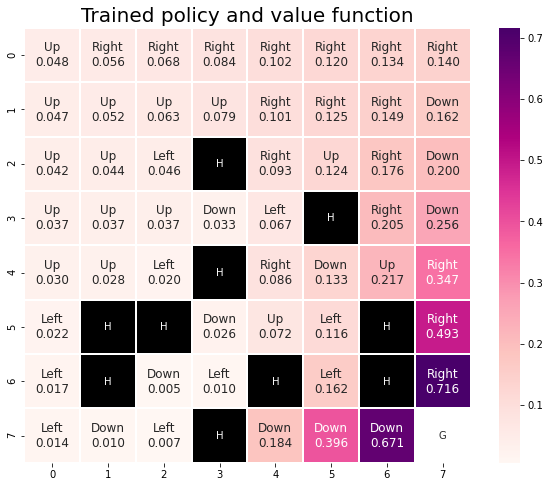

In [9]:
# For visualization, the actions of the policy were converted to strings.
act_str = {0:'Left', 1:'Down', 2:"Right", 3:"Up"}
policy_str = np.array([act_str[i] for i in policy])
label = np.array(["{}\n{:.3f}".format(p,v) for p, v in zip(policy_str, v_table)])

plt.figure(figsize=(10,8))
plt.title('Trained policy and value function', fontsize=20)
sns.heatmap(map_float, annot=np.array(desc).reshape(8,8), fmt='', cbar=False, linewidths=1, cmap="gray", mask=1-terminal_place.reshape(8,8))
sns.heatmap(v_table.reshape(8,8), annot=label.reshape(8,8), fmt='',linewidths=1, cmap="RdPu", mask=terminal_place.reshape(8,8), annot_kws={"size": 12})
plt.show()


### Improving policy iteration

It may take a lot of time in policy evalution when we perform multiple sweeps (one sweep is one update of all states) until the value function converges. In fact, it is not necessary to converge the value function in every step of policy evalution (we can use truncated policy iteration). We can think of a case where only one sweep of the value function is performed in the policy evaluation, and this case is called "value iteration".

# 2. Value iteration

As mentioned earlier, value iteration is an iteration of truncated policy evalutaion with one sweep and policy improvement. In other words, this is equivalent to first finding the optimal value function by iteration through the Bellman optimal equation, and then finding the optimal policy from it.

Declare a function for value iteration.

In [10]:
def prediction(env, v_table):
    # update v_table with optimal policy
    v_table_old = copy.deepcopy(v_table)  
    for s in range(env.nS):
        if terminal_place[s] : continue # we don't need value function here
        max_target = -np.inf
        for a in range(env.nA):
            target = np.sum([p * (r + gamma * v_table_old[s_] * (1- d)) for p, s_, r, d in env.P[s][a]])
            max_target = max(max_target, target)
        v_table[s] = max_target 
    delta = np.max(np.abs(v_table - v_table_old))
    
    return v_table, delta 

def control(v_table):
    # update policy using current v_table
    for s in range(env.nS):
        expected_return = np.zeros(shape=(env.nA))
        for a in range(env.nA):
            for p, s_, r, d in env.P[s][a]:
                expected_return[a] += p * (r + gamma * v_table[s_] * (1- d))
        policy[s] = np.argmax(expected_return)
    return policy

The main loop of value iteration is as follows.

In [11]:
# Initializing Value function and policy
v_table = np.random.randn(env.nS)
gamma= 0.95
num_iteration = 0
while True:
    num_iteration += 1
    # value function update
    v_table, delta = prediction(env, v_table)
    if delta <0.00001:
        break
print("Number of iteration : ", num_iteration)    

# get optimal policy 
policy = control(v_table)
    


Number of iteration :  129


"Number of iteration" refers to the number of times the value function is updated until the optimal policy is obtained. Let's compare it with the that of the policy iteration.

Let's check the trained value function. We can see that it converges to the same value function in the policy iteration method.

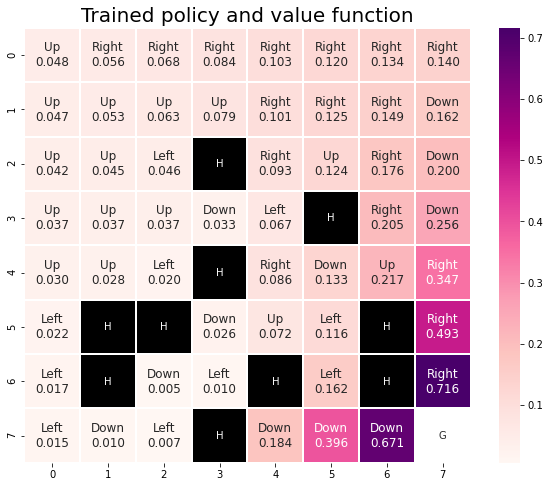

In [12]:
# For visualization, the actions of the policy were converted to strings.
policy_str = np.array([act_str[i] for i in policy])
label = np.array(["{}\n{:.3f}".format(p,v) for p, v in zip(policy_str, v_table)])

plt.figure(figsize=(10,8))
plt.title('Trained policy and value function', fontsize=20)
sns.heatmap(map_float, annot=np.array(desc).reshape(8,8), fmt='', cbar=False, linewidths=1, cmap="gray", mask=1-terminal_place.reshape(8,8))
sns.heatmap(v_table.reshape(8,8), annot=label.reshape(8,8), fmt='',linewidths=1, cmap="RdPu", mask=terminal_place.reshape(8,8), annot_kws={"size": 12})
plt.show()


### Test

Finially, we can evaluate the trained policy. We can see how the agent moves for each step.

In [13]:
time_limit = 200
trial_num = 10
total_arrive=[]
for i in range(trial_num):
    s = env.reset()
    for _ in range(time_limit):
        time.sleep(0.01)
        clear_output(wait=True)
        a = policy[s]
        (s, r, d, p) = env.step(a)
        print("Trial : %d/%d" %(i+1,trial_num))
        env.render()
        if d : 
            break
    # check whether arrvied or not
    if s == 63: # arrived
        total_arrive.append(1)
    else : # Fall or time out
        total_arrive.append(0)
env.close()
print("\nTrial : {}, Arrival : {}, Arrival rate : {}".format(trial_num, np.sum(total_arrive), np.sum(total_arrive)/trial_num))

Trial : 10/10
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Trial : 10, Arrival : 9, Arrival rate : 0.9
